In [43]:
%cd '/mnt/c/Users/malin/Documents/Facultate/honours/UMCG/ICU_Augment_and_Detect'

/mnt/c/Users/malin/Documents/Facultate/honours/UMCG/ICU_Augment_and_Detect


In [44]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import cv2
import os
import sys
import numpy as np
import pickle
import sklearn.metrics
import random

sys.path.append(os.getcwd())

from augment.face_org import *

In [50]:
def load_data(folder_sick, folder_healthy, image_size, type):
    files_healthy = os.listdir(folder_healthy)
    files_sick = os.listdir(folder_sick)
    data = []
    labels = []
    for filename in files_healthy:
        sick = np.array([0,1])
        full_path = folder_healthy + "/" + str(filename)
        if type in filename and os.path.isfile(full_path) and "n2" not in filename:
            image = cv2.imread(full_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, dsize=(
                image_size, image_size), interpolation=cv2.INTER_CUBIC)
            data.append(np.asarray(image, dtype=np.int32))
            labels.append(np.asarray(sick, dtype=np.int32))
    for filename in files_sick:
        sick = np.array([1,0])
        full_path = folder_sick + "/" + str(filename)
        if type in filename and os.path.isfile(full_path):
            image = cv2.imread(full_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, dsize=(
                image_size, image_size), interpolation=cv2.INTER_CUBIC)
            data.append(np.asarray(image, dtype=np.int32))
            labels.append(np.asarray(sick, dtype=np.int32))
    return np.asarray(data, dtype=np.float64) / 255, np.asarray(labels, dtype=np.int32)


def load_shuffled_data(folder_sick, folder_healthy, image_size, type):
    data, labels = load_data(folder_sick, folder_healthy, image_size, type)
    permutation = np.random.permutation(len(data))
    return data[permutation], labels[permutation]


def make_model(image_size, feature):
    model = models.Sequential()

    model.add(layers.Conv2D(image_size, (3, 3), padding="same", activation='relu',
                            input_shape=(image_size, image_size, 3),
                            name="input_" + str(feature)))

    model.add(layers.BatchNormalization(name="batch1_" + str(feature)))
    model.add(layers.Conv2D(int(image_size / 2), (3, 3),
                            activation='relu', name="conv1_" + str(feature)))
    model.add(layers.BatchNormalization(name="batch2_" + str(feature)))
    model.add(layers.MaxPooling2D((2, 2), name="max1_" + str(feature)))

    model.add(layers.Conv2D(int(image_size/4), (3, 3),
                            activation='relu', name="conv2_" + str(feature)))
    model.add(layers.BatchNormalization(name="batch3_" + str(feature)))
    model.add(layers.MaxPooling2D((2, 2), name="max2_" + str(feature)))

    model.add(layers.Conv2D(int(image_size/8), (3, 3),
                            activation='relu', name="conv5_" + str(feature)))
    model.add(layers.BatchNormalization(name="batch6_" + str(feature)))
    model.add(layers.MaxPooling2D((2, 2), name="max3_" + str(feature)))

    model.add(layers.Conv2D(int(image_size/16), (3, 3),
                            activation='relu', name="conv6_" + str(feature)))
    model.add(layers.BatchNormalization(name="batch7_" + str(feature)))
    model.add(layers.AveragePooling2D((2, 2), name="avg1_" + str(feature)))

    model.add(layers.Flatten(name="flatten_" + str(feature)))
    model.add(layers.Dense(48, activation='relu',
                           name="dense1_" + str(feature)))
    model.add(layers.Dropout(0.3, name="dropout1_" + str(feature)))

    model.add(layers.Dense(16, activation='relu',
                           name="dense2_" + str(feature)))
    model.add(layers.Dropout(0.5, name="dropout2_" + str(feature)))

    model.add(layers.Dense(2, activation='softmax',
                           name="dense3_" + str(feature)))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss="binary_crossentropy",
                  metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

    return model

# def auc(y_true, y_pred):
#     auc = tf.metrics.AUC(y_true, y_pred)[1]
#     K.get_session().run(tf.local_variables_initializer())
#     return auc

def load_data_eyes(image_folder_sick, image_folder_healthy, image_size):
    images_left, labels_left = load_shuffled_data(
        image_folder_sick, image_folder_healthy, image_size, "left")
    images_right, labels_right = load_shuffled_data(
        image_folder_sick, image_folder_healthy, image_size, "right")

    images = np.concatenate((images_left, images_right), axis=0)
    labels = np.concatenate((labels_left, labels_right), axis=0)

    permutation = np.random.permutation(len(images))

    return images[permutation], labels[permutation]


def save_history(save_path, history, feature, i):
    if i != 0:
        with open(save_path + str(feature) + "/history_" + str(i) + ".pickle", 'wb') as file_pi:
            pickle.dump(history.history, file_pi)
    else:
        with open(save_path + str(feature) + "/history.pickle", 'wb') as file_pi:
            pickle.dump(history.history, file_pi)

In [53]:
if __name__ == "__main__":

    image_folder_sick = 'data/parsed/sick'
    image_folder_healthy = 'data/parsed/healthy'
    image_folder_val_sick = 'data/parsed/validation-sick'
    image_folder_val_healthy = 'data/parsed/validation-healthy'
    save_path = 'categorization/model_saves/'
    image_size = 128
    # face_features = ["mouth", "face", "skin", "eyes"]
    face_features = ['mouth']

    for feature in face_features:

        print("[INFO] Training %s" % (feature))

        if feature == "eyes":
            test_images, test_labels = load_data_eyes(
                image_folder_val_sick, image_folder_val_healthy, image_size)
            train_images, train_labels = load_data_eyes(
                image_folder_sick, image_folder_healthy, image_size)

        else:
            test_images, test_labels = load_shuffled_data(
                image_folder_val_sick, image_folder_val_healthy, image_size, feature)
            train_images, train_labels = load_shuffled_data(
                image_folder_sick, image_folder_healthy, image_size, feature)

        model = make_model(image_size, feature)
        # model.summary()
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_recall_2', mode = 'max', patience=5, verbose = 1)
        model_check = tf.keras.callbacks.ModelCheckpoint(save_path + str(feature)+ '.h5', monitor='val_recall_2', mode='max', verbose=1, save_best_only=True)

        history = model.fit(train_images, train_labels, epochs=20,
                            batch_size=32, callbacks = [early_stopping, model_check], validation_data=(test_images, test_labels))

        # model.save(save_path + str(feature) + "/save.h5"
        save_history(save_path, history, feature, 0)

        saved_model = tf.keras.models.load_model(save_path + str(feature)+ '.h5')

[INFO] Training mouth
Train on 52 samples, validate on 44 samples
Epoch 1/20
32/52 [=================>............] - ETA: 3s - loss: 1.2464 - accuracy: 0.3750 - recall_2: 0.3750 - precision_2: 0.3750
Epoch 00001: val_recall_2 improved from -inf to 0.50000, saving model to categorization/model_saves/mouth.h5
52/52 [==============================] - 10s 192ms/sample - loss: 1.3106 - accuracy: 0.3462 - recall_2: 0.3462 - precision_2: 0.3462 - val_loss: 0.6931 - val_accuracy: 0.5000 - val_recall_2: 0.5000 - val_precision_2: 0.5000
Epoch 2/20
32/52 [=================>............] - ETA: 2s - loss: 0.7872 - accuracy: 0.6250 - recall_2: 0.6250 - precision_2: 0.6250
Epoch 00002: val_recall_2 did not improve from 0.50000
52/52 [==============================] - 6s 122ms/sample - loss: 0.7614 - accuracy: 0.5769 - recall_2: 0.5769 - precision_2: 0.5769 - val_loss: 0.6936 - val_accuracy: 0.5000 - val_recall_2: 0.5000 - val_precision_2: 0.5000
Epoch 3/20
32/52 [=================>............] - E

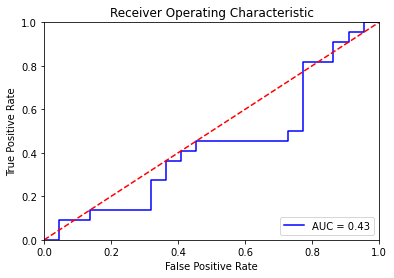

In [54]:
pred = saved_model.predict(test_images)
fpr, tpr, threshold = sklearn.metrics.roc_curve(test_labels[:,0], pred[:,0])
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [24]:
plt.plot(history["accuracy"], label = "Training accuracy")
plt.plot(history["val_accuracy"], label = "Validation accuracy")
plt.legend()
plt.ylim((0.5,1.05))
plt.xlim((0,20))
plt.xlabel('Training Epochs')
plt.ylabel('Accuracy')
plt.title("Accuracy of the Best Stacked Model")
plt.savefig("data/plots/best_stacked_accuracy.png")


TypeError: 'History' object is not subscriptable